In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler
import torch.nn.functional as F
# Đọc file CSV thành DataFrame
df = pd.read_csv("top50_daily.csv")
df.head()


,STT,TEXT,COUNT,VIDEO
0,1,thương yêu,6,"W03373B.mp4, W03373N.mp4, W03373T.mp4, W03450B..."
1,2,đặc biệt,4,"W01122B.mp4, W01122T.mp4, W01122N.mp4, W01122.mp4"
2,3,thành lập,4,"W03175N.mp4, W03175T.mp4, W03175B.mp4, W03175.mp4"
3,4,thường xuyên,4,"D0156N.mp4, D0156B.mp4, D0156.mp4, D0156T.mp4"
4,5,tưởng tượng,4,"W03732T.mp4, W03732.mp4, W03732N.mp4, W03732B.mp4"


In [2]:
df[["TEXT", "VIDEO"]]

,TEXT,VIDEO
0,thương yêu,"W03373B.mp4, W03373N.mp4, W03373T.mp4, W03450B..."
1,đặc biệt,"W01122B.mp4, W01122T.mp4, W01122N.mp4, W01122.mp4"
2,thành lập,"W03175N.mp4, W03175T.mp4, W03175B.mp4, W03175.mp4"
3,thường xuyên,"D0156N.mp4, D0156B.mp4, D0156.mp4, D0156T.mp4"
4,tưởng tượng,"W03732T.mp4, W03732.mp4, W03732N.mp4, W03732B.mp4"
5,bộ đội,"W00328N.mp4, W00328T.mp4, W00328B.mp4"
6,bình thường,"W00286N.mp4, W00286B.mp4, W00286T.mp4"
7,sữa bột,"W03037T.mp4, W03037B.mp4, W03037N.mp4"
8,sữa dê,"W03038N.mp4, W03038T.mp4, W03038B.mp4"
9,sữa bò,"W03036T.mp4, W03036B.mp4, W03036N.mp4"


In [3]:
for i in df.index:
    files = [x.strip() for x in df.loc[i, "VIDEO"].split(",")]
    print(f"Processing row {i}: {files}")

Processing row 0: ['W03373B.mp4', 'W03373N.mp4', 'W03373T.mp4', 'W03450B.mp4', 'W03450T.mp4', 'W03450N.mp4']
Processing row 1: ['W01122B.mp4', 'W01122T.mp4', 'W01122N.mp4', 'W01122.mp4']
Processing row 2: ['W03175N.mp4', 'W03175T.mp4', 'W03175B.mp4', 'W03175.mp4']
Processing row 3: ['D0156N.mp4', 'D0156B.mp4', 'D0156.mp4', 'D0156T.mp4']
Processing row 4: ['W03732T.mp4', 'W03732.mp4', 'W03732N.mp4', 'W03732B.mp4']
Processing row 5: ['W00328N.mp4', 'W00328T.mp4', 'W00328B.mp4']
Processing row 6: ['W00286N.mp4', 'W00286B.mp4', 'W00286T.mp4']
Processing row 7: ['W03037T.mp4', 'W03037B.mp4', 'W03037N.mp4']
Processing row 8: ['W03038N.mp4', 'W03038T.mp4', 'W03038B.mp4']
Processing row 9: ['W03036T.mp4', 'W03036B.mp4', 'W03036N.mp4']
Processing row 10: ['W00304N.mp4', 'W00304B.mp4', 'W00304T.mp4']
Processing row 11: ['W03011B.mp4', 'W03011T.mp4', 'W03011N.mp4']
Processing row 12: ['W00326B.mp4', 'W00326T.mp4', 'W00326N.mp4']
Processing row 13: ['W00459T.mp4', 'W00459N.mp4', 'W00459B.mp4']
Pro

In [4]:
#shape of vid:
cap = cv2.VideoCapture("Dataset/Video/D0001B.mp4")
if not cap.isOpened():
    print("Error: Could not open video.")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Video shape: {width}x{height}, FPS: {fps}")

Video shape: 1280x720, FPS: 29.97002997002997


In [5]:
def draw_keypoints(frame, keypoints):
    for point in keypoints:
        x, y = int(point[0] * frame.shape[1]), int(point[1] * frame.shape[0])
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    return frame

In [6]:
import cv2

def extract_frame(video_path: str, n: int, save_path: str | None = None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Không mở được {video_path}")

    # Nhảy tới khung thứ n (đếm từ 0)
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)

    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise ValueError(f"Khung {n} > tổng số khung của video")

    if save_path:
        cv2.imwrite(save_path, frame)   # lưu ra file ảnh
    return frame                       # hoặc trả về mảng numpy


In [ ]:
import mediapipe as mp
from config import Config
from detector import MediaPipeProcessor

pose = MediaPipeProcessor(Config())
results = []
def extract_video_keypoint(video_path):
    keypoints = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(image_rgb)
        frame_keypoints = pose.extract_keypoints(result)
        results.append(result)
        keypoints.append(frame_keypoints)
    cap.release()
    return keypoints, results

2025-06-22 02:38:05.073504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 02:38:05.083614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750534685.095908   22742 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750534685.099542   22742 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-22 02:38:05.112521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [8]:
kpts, res = extract_video_keypoint("Dataset/Video/D0001B.mp4")
kpts

KeyboardInterrupt: 

In [ ]:
for i, label, file_name in zip(df.index, df["TEXT"], df["VIDEO"]):
    files = [x.strip() for x in file_name.split(",")]
    for file in files:
        print(f"Processing row {i}: {label} {file}")

Processing row 0: thương yêu W03373B.mp4
Processing row 0: thương yêu W03373N.mp4
Processing row 0: thương yêu W03373T.mp4
Processing row 0: thương yêu W03450B.mp4
Processing row 0: thương yêu W03450T.mp4
Processing row 0: thương yêu W03450N.mp4
Processing row 1: đặc biệt W01122B.mp4
Processing row 1: đặc biệt W01122T.mp4
Processing row 1: đặc biệt W01122N.mp4
Processing row 1: đặc biệt W01122.mp4
Processing row 2: thành lập W03175N.mp4
Processing row 2: thành lập W03175T.mp4
Processing row 2: thành lập W03175B.mp4
Processing row 2: thành lập W03175.mp4
Processing row 3: thường xuyên D0156N.mp4
Processing row 3: thường xuyên D0156B.mp4
Processing row 3: thường xuyên D0156.mp4
Processing row 3: thường xuyên D0156T.mp4
Processing row 4: tưởng tượng W03732T.mp4
Processing row 4: tưởng tượng W03732.mp4
Processing row 4: tưởng tượng W03732N.mp4
Processing row 4: tưởng tượng W03732B.mp4
Processing row 5: bộ đội W00328N.mp4
Processing row 5: bộ đội W00328T.mp4
Processing row 5: bộ đội W00328B

In [ ]:
# import numpy as np

# for i, file_names in zip(df.index, df["VIDEO"]):
#     print(f"Processing row {i}: {file_names}")
#     files = [x.strip() for x in file_names.split(",")]
#     for file in files:
#         video_path = f"data/Video_60frames/{file}"
#         keypoints, _ = extract_video_keypoint(video_path)
#         file_name = file.split(".")[0]
#         np.save(f"data/Keypoints/{file_name}.npy", keypoints)
#         print(f"Saved keypoints for {file} to data/keypoints/{file_name}.npy", len(keypoints))
        

In [ ]:
class LoadData(Dataset):
    """
    Dataset that selects frames at indices [offset, offset+5, offset+10, ...]
    without truncation. Returns raw sequence per sample.
    Keypoints loaded from keypoints_dir (.npy shape: (T, F)).
    Labels loaded from label_dir   (.npy shape: (T,)).
    """
    def __init__(self, keypoints_dir, label_dir, offset):
        self.keypoints_dir = keypoints_dir
        self.label_dir = label_dir
        self.offset = offset
        # find common base filenames
        kp_files = {os.path.splitext(f)[0] for f in os.listdir(keypoints_dir) if f.endswith('.npy')}
        lbl_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir)   if f.endswith('.npy')}
        self.common = sorted(kp_files & lbl_files)

    def __len__(self):
        return len(self.common)

    def __getitem__(self, idx):
        base = self.common[idx]
        # load full sequences
        kp_seq = np.load(os.path.join(self.keypoints_dir, f"{base}.npy"))  # (T, F)
        lbl_seq= np.load(os.path.join(self.label_dir,   f"{base}.npy"))   # (T,)
        # select every 5th frame starting at offset
        seq_kp = kp_seq[self.offset::5]
        seq_lbl= lbl_seq[self.offset::5]
        # convert to tensors directly (length may vary per sample)
        return torch.from_numpy(seq_kp).float(), torch.from_numpy(seq_lbl).long()

In [ ]:
def create_dataloaders(keypoints_dir, label_dir, batch_size=32):
    """
    Creates train and validation DataLoaders padded to the max sequence length across the entire dataset.
    Offsets 0-3 for train, offset 4 for val. No truncation; pad at beginning.
    """
    # instantiate datasets for each offset
    train_datasets = [LoadData(keypoints_dir, label_dir, offs) for offs in range(4)]
    val_dataset    = LoadData(keypoints_dir, label_dir, 4)
    train_ds = ConcatDataset(train_datasets)

    # compute global max length across both train and val
    all_ds = ConcatDataset(train_datasets + [val_dataset])
    max_len = 0
    for kp, _ in all_ds:
        if kp.shape[0] > max_len:
            max_len = kp.shape[0]

    # custom collate function
    def collate_pad_to_max(batch):
        kp_seqs, lbl_seqs = zip(*batch)
        F = kp_seqs[0].shape[1]
        kp_batch, lbl_batch = [], []
        for kp_seq, lbl_seq in zip(kp_seqs, lbl_seqs):
            L = kp_seq.shape[0]
            pad_count = max_len - L

            if pad_count > 0:
                pad_shape = (pad_count, *kp_seq.shape[1:])  
                pad_kp = torch.zeros(pad_shape, dtype=kp_seq.dtype, device=kp_seq.device)
                pad_lbl = torch.zeros((pad_count,), dtype=lbl_seq.dtype, device=lbl_seq.device)
                kp_seq = torch.cat([pad_kp, kp_seq], dim=0)
                lbl_seq = torch.cat([pad_lbl, lbl_seq], dim=0)
            kp_batch.append(kp_seq)
            lbl_batch.append(lbl_seq)
        kp_batch = torch.stack(kp_batch, dim=0)  # (B, max_len, F)
        lbl_batch= torch.stack(lbl_batch, dim=0) # (B, max_len)
        return kp_batch, lbl_batch

    # DataLoaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_pad_to_max
    )
    train_labels = []
    for seq, lbl in train_loader:
        for i in range(lbl.shape[0]):
            train_labels.append(int(lbl[i, -1].item()))

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_pad_to_max
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_pad_to_max
    )
    return train_loader, val_loader, max_len

In [ ]:
kp_dir = 'data/Keypoints'
lbl_dir= 'data/Labels'
train_loader, val_loader, global_max_len = create_dataloaders(
    kp_dir, lbl_dir, batch_size=32
)
print(f"Global max sequence length: {global_max_len}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")

# Inspect first batch
for kp_batch, lbl_batch in train_loader:
    print(f"Batch keypoints shape: {kp_batch.shape}")  # (B, global_max_len, F)
    print(f"Batch labels shape:    {lbl_batch.shape}")  # (B, global_max_len)
    break

Global max sequence length: 39
Train batches: 20
Val batches:   5
Batch keypoints shape: torch.Size([32, 39, 75, 2])
Batch labels shape:    torch.Size([32, 39])


In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, A):
        super(GCNLayer, self).__init__()
        self.A = A
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        # x: (B, T, V, C)
        B, T, V, C = x.size()
        x = x.view(B * T, V, C)  # (B*T, V, C)
        A = self.A.to(x.device)  # (V, V)
        x = torch.matmul(A, x)   # (B*T, V, C)
        x = self.fc(x)           # (B*T, V, out_features)
        x = x.view(B, T, V, -1)
        return x

class THGC_LSTM(nn.Module):
    def __init__(self, in_channels, hidden_gcn, hidden_lstm, num_classes, A, dropout=0.5):
        super(THGC_LSTM, self).__init__()
        self.gcn1 = GCNLayer(in_channels, hidden_gcn, A)
        self.gcn2 = GCNLayer(hidden_gcn, hidden_gcn, A)
        self.pool = nn.AdaptiveAvgPool2d((None, 1))  # pool over joints (V)
        self.lstm = nn.LSTM(hidden_gcn, hidden_lstm, batch_first=True)
        self.fc = nn.Linear(hidden_lstm, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, T, V, C)
        x = self.gcn1(x)  # (B, T, V, H)
        x = F.relu(x)
        x = self.gcn2(x)  # (B, T, V, H)
        x = F.relu(x)
        x = x.permute(0, 3, 1, 2)  # (B, H, T, V)
        x = self.pool(x).squeeze(-1)  # (B, H, T)
        x = x.permute(0, 2, 1)  # (B, T, H)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)  # (B, T, H_lstm)
        x = x[:, -1]  # last time step
        x = self.dropout(x)
        x = self.fc(x)  # (B, num_classes)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score

def train_thgc_lstm(
    model: nn.Module,
    train_loader,
    val_loader,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
    device,
    window_size: int = 15,
    num_epochs: int = 10
):
    """
    Train the THGC-LSTM model using sliding windows on 4D keypoint data,
    computing loss, accuracy, precision, recall and F1 (excluding classes 0 and 1),
    with manual re-normalization of the weighted per-sample loss.
    """
    model.to(device)

    # grab the class_weights you passed into criterion
    # (we'll use them directly)
    class_weights = criterion.weight
    num_classes = class_weights.size(0)

    # only compute metrics on labels ≥2
    valid_labels = list(range(2, num_classes))

    history = {
        'train_loss': [], 'train_acc': [], 'train_prec': [], 'train_rec': [], 'train_f1': [],
        'val_loss':   [], 'val_acc':   [], 'val_prec':   [], 'val_rec':   [], 'val_f1':    [],
    }

    for epoch in range(1, num_epochs + 1):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        n_windows = 0
        all_true, all_pred = [], []

        for seqs, lbls in train_loader:
            seqs, lbls = seqs.to(device), lbls.to(device)
            B, T, V, C = seqs.shape
            if T < window_size:
                continue

            windows = (
                seqs
                .unfold(1, window_size, 1)
                .contiguous()
                .view(-1, window_size, V, C)
            )
            targets = lbls[:, window_size - 1:].contiguous().view(-1)

            optimizer.zero_grad()
            logits = model(windows)  # (N_win, num_classes)

            # get per-sample CE loss without any reduction
            raw = F.cross_entropy(logits, targets,
                                  weight=class_weights,
                                  reduction='none')
            # normalize by sum of the weights in this batch
            w_batch = class_weights[targets]
            loss = raw.sum() / w_batch.sum()

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * windows.size(0)
            n_windows   += windows.size(0)

            preds = logits.argmax(dim=1)
            all_true.append(targets.cpu())
            all_pred.append(preds.cpu())

        # compute train metrics (exclude class 0 & 1)
        train_loss = running_loss / n_windows if n_windows else 0.0
        y_true = torch.cat(all_true).numpy()
        y_pred = torch.cat(all_pred).numpy()
        mask   = y_true > 1
        y_true, y_pred = y_true[mask], y_pred[mask]

        train_acc  = (y_true == y_pred).mean() if y_true.size else 0.0
        train_prec = precision_score(y_true, y_pred,
                                     labels=valid_labels,
                                     average='macro',
                                     zero_division=0)
        train_rec  = recall_score(y_true, y_pred,
                                  labels=valid_labels,
                                  average='macro',
                                  zero_division=0)
        train_f1   = f1_score(y_true, y_pred,
                              labels=valid_labels,
                              average='macro',
                              zero_division=0)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_windows = 0
        all_true, all_pred = [], []

        with torch.no_grad():
            for seqs, lbls in val_loader:
                seqs, lbls = seqs.to(device), lbls.to(device)
                B, T, V, C = seqs.shape
                if T < window_size:
                    continue

                windows = (
                    seqs
                    .unfold(1, window_size, 1)
                    .contiguous()
                    .view(-1, window_size, V, C)
                )
                targets = lbls[:, window_size - 1:].contiguous().view(-1)

                logits = model(windows)

                raw = F.cross_entropy(logits, targets,
                                      weight=class_weights,
                                      reduction='none')
                w_batch = class_weights[targets]
                loss = raw.sum() / w_batch.sum()

                val_loss   += loss.item() * windows.size(0)
                val_windows += windows.size(0)

                preds = logits.argmax(dim=1)
                all_true.append(targets.cpu())
                all_pred.append(preds.cpu())

        val_loss = val_loss / val_windows if val_windows else 0.0
        y_true = torch.cat(all_true).numpy()
        y_pred = torch.cat(all_pred).numpy()
        mask   = y_true > 1
        y_true, y_pred = y_true[mask], y_pred[mask]

        val_acc  = (y_true == y_pred).mean() if y_true.size else 0.0
        val_prec = precision_score(y_true, y_pred,
                                   labels=valid_labels,
                                   average='macro',
                                   zero_division=0)
        val_rec  = recall_score(y_true, y_pred,
                                labels=valid_labels,
                                average='macro',
                                zero_division=0)
        val_f1   = f1_score(y_true, y_pred,
                            labels=valid_labels,
                            average='macro',
                            zero_division=0)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_prec'].append(train_prec)
        history['train_rec'].append(train_rec)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train L: {train_loss:.4f}  Acc: {train_acc:.4f}  "
              f"P: {train_prec:.4f}  R: {train_rec:.4f}  F1: {train_f1:.4f} | "
              f"Val   L: {val_loss:.4f}  Acc: {val_acc:.4f}  "
              f"P: {val_prec:.4f}  R: {val_rec:.4f}  F1: {val_f1:.4f}")

    return history


In [ ]:
import numpy as np
N=75
A = np.zeros((N, N), dtype=np.int32)
POSE_CONNECTIONS = frozenset([
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5),
    (5, 6), (6, 8), (9, 10), (11, 12), (11, 13),
    (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),
    (18, 20), (11, 23), (12, 24), (23, 24), (23, 25),
    (24, 26), (25, 27), (26, 28), (27, 29), (28, 30),
    (29, 31), (30, 32), (27, 31), (28, 32)
])

HAND_PALM_CONNECTIONS = ((0, 1), (0, 5), (9, 13), (13, 17), (5, 9), (0, 17))

HAND_THUMB_CONNECTIONS = ((1, 2), (2, 3), (3, 4))

HAND_INDEX_FINGER_CONNECTIONS = ((5, 6), (6, 7), (7, 8))

HAND_MIDDLE_FINGER_CONNECTIONS = ((9, 10), (10, 11), (11, 12))

HAND_RING_FINGER_CONNECTIONS = ((13, 14), (14, 15), (15, 16))

HAND_PINKY_FINGER_CONNECTIONS = ((17, 18), (18, 19), (19, 20))

HAND_CONNECTIONS = frozenset().union(*[
    HAND_PALM_CONNECTIONS, HAND_THUMB_CONNECTIONS,
    HAND_INDEX_FINGER_CONNECTIONS, HAND_MIDDLE_FINGER_CONNECTIONS,
    HAND_RING_FINGER_CONNECTIONS, HAND_PINKY_FINGER_CONNECTIONS
])

# 4. Điền cạnh cho pose (chính giữa mảng coords, indices 0..32)
for i, j in POSE_CONNECTIONS:
    A[i, j] = 1
    A[j, i] = 1

# 5. Điền cạnh cho left hand (offset = pose_len)
for i, j in HAND_CONNECTIONS:
    u, v = i + 33, j + 33
    A[u, v] = 1
    A[v, u] = 1

# 6. Điền cạnh cho right hand (offset = pose_len + lh_len)
offset_rh = 33 + 20
for i, j in HAND_CONNECTIONS:
    u, v = i + offset_rh, j + offset_rh
    A[u, v] = 1
    A[v, u] = 1

# 7. (Tuỳ chọn) thêm self‐loop
np.fill_diagonal(A, 1)

# Kết quả: A là ma trận 63×63
np.set_printoptions(threshold=np.inf)
print("Adjacency matrix shape:", A.shape)

Adjacency matrix shape: (75, 75)


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1
feature_size = 75
hidden_size = 128
in_channels = 2
num_classes = 52
bidirectional = False
dropout = 0.5
window_size = 15
num_epochs = 150
batch_size = 16
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loaders returning full sequences (e.g., 64 frames)
kp_dir = 'data/Keypoints'
lbl_dir = 'data/Labels'
train_loader, val_loader, _ = create_dataloaders(kp_dir, lbl_dir, batch_size=batch_size)
# Model, criterion, optimizer
# model = TCNClassifier(feature_size, num_channels, num_classes, dropout=dropout)
model = THGC_LSTM(
    in_channels=in_channels,
    hidden_gcn=hidden_size,
    hidden_lstm=hidden_size,
    num_classes=num_classes,
    A=torch.tensor(A, dtype=torch.float32),
    dropout=dropout
)
model.to(device)
class_weights = torch.ones(num_classes, device=device)
class_weights[0] = 0.05
class_weights[1] = 0.05
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_hist = train_thgc_lstm(model, train_loader, val_loader, criterion, optimizer, device, window_size, num_epochs)

env: CUDA_LAUNCH_BLOCKING=1
Epoch 1/150 | Train L: 3.0326  Acc: 0.0016  P: 0.0067  R: 0.0017  F1: 0.0027 | Val   L: 2.7020  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000
Epoch 2/150 | Train L: 2.7221  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000 | Val   L: 2.5945  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000
Epoch 3/150 | Train L: 2.6224  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000 | Val   L: 2.5217  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000
Epoch 4/150 | Train L: 2.5448  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000 | Val   L: 2.4254  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000
Epoch 5/150 | Train L: 2.4748  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000 | Val   L: 2.3997  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000
Epoch 6/150 | Train L: 2.4190  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000 | Val   L: 2.3474  Acc: 0.0000  P: 0.0000  R: 0.0000  F1: 0.0000
Epoch 7/150 | Train L: 2.3791  Acc: 0.0032  P: 0.0050  R: 0.0033  F1: 0.0040 | Val   L: 2.2840  Acc: 0.0000  P: 0.0000  

In [ ]:
def inference(
    model: nn.Module,
    seq: torch.Tensor,
    device: torch.device,
    window_size: int = 15
) -> torch.Tensor:
    model.eval()
    # if input flattened (T, F), reshape to (T, V, C)
    if seq.ndim == 2:
        T, F = seq.size()
        for C in (3, 2):
            if F % C == 0:
                V = F // C
                seq = seq.view(T, V, C)
                break
    seq = seq.to(device)
    T, V, C = seq.size()
    if T < window_size:
        return torch.tensor([], dtype=torch.long)
    # build sliding windows: (num_windows, window_size, V, C)
    windows = torch.stack(
        [seq[i:i + window_size] for i in range(T - window_size + 1)],
        dim=0
    )
    with torch.no_grad():
        logits = model(windows)           # (num_windows, num_classes)
        preds = torch.argmax(logits, dim=1)
    return preds.cpu()

Preds: [0, 0, 0, 0, 48, 0, 0, 0, 0, 48, 48, 48, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5]
Preds: [0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 5, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 0, 0, 0, 34, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0, 0, 0, 0, 0, 0, 34, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Truth: [0,

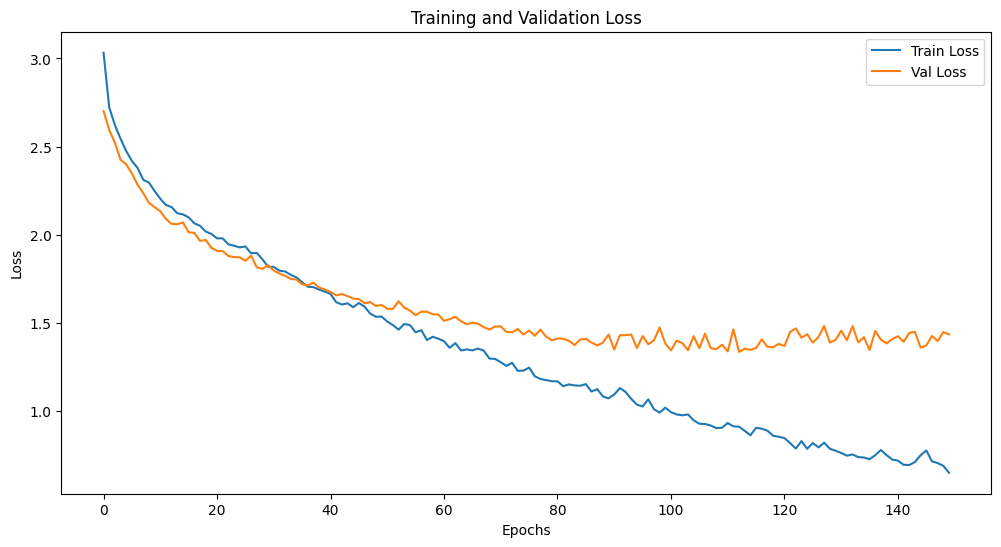

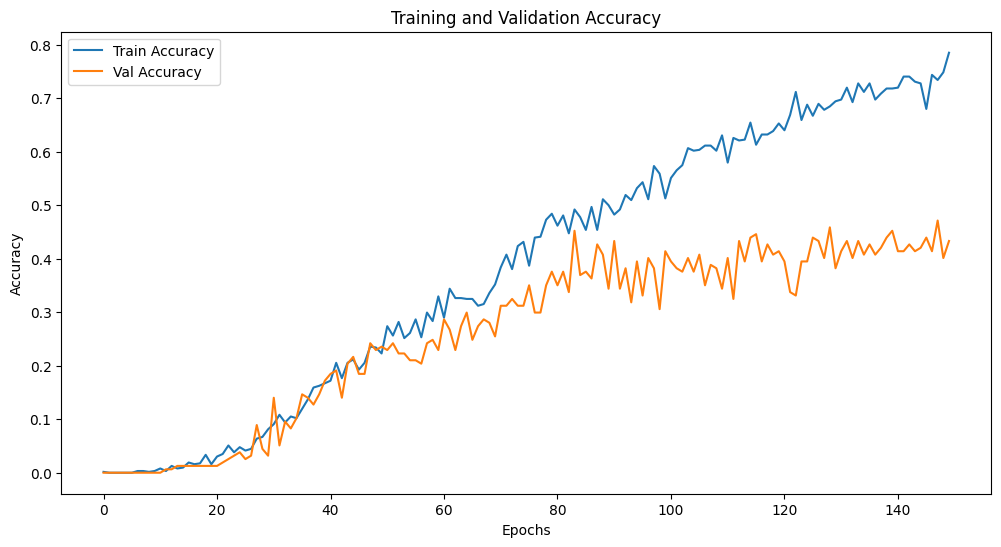

In [ ]:
for seq, lbls in val_loader.dataset:
        preds = inference(model, seq, device, window_size)
        print(f"Preds: {preds.tolist()}  Truth: {lbls[window_size-1:].tolist()}")

# --- Evaluation on full validation set ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Remove seaborn dependency; use matplotlib for confusion matrix
import matplotlib.pyplot as plt

all_preds, all_truths = [], []
for seq, lbls in val_loader.dataset:
    preds = inference(model, seq, device, window_size)
    truths = lbls[window_size-1:].tolist()
    all_preds.extend(preds.tolist())
    all_truths.extend(truths)

acc = accuracy_score(all_truths, all_preds)
print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(all_truths, all_preds, zero_division=0))
#show history train and val loss
plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train_loss'], label='Train Loss')
plt.plot(loss_hist['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
#show history train and val acc
plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train_acc'], label='Train Accuracy')
plt.plot(loss_hist['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
#take vide from data/datatest and inference mediapipe keypoints and inference model
def process_video(video_path, model, device, window_size=15):
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps // 6)
    frame_count = 0
    if frame_interval == 0:
        frame_interval = 1
    if not cap.isOpened():
        raise IOError(f"Không mở được {video_path}")

    keypoints = np.zeros((window_size, 126), dtype=np.float32)  # Assuming 126 keypoints per frame
    results = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval != 0:
            frame_count += 1
            continue
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(image_rgb)
        frame_keypoints = pose.extract_keypoints(result)
        #add frame_keypoints to keypoints
        keypoints = np.vstack((keypoints, frame_keypoints))
        keypoints = np.array(keypoints[1:])
        seq_tensor = torch.from_numpy(keypoints).float().to(device)
        preds = inference(model, seq_tensor, device, window_size)
        preds = preds.cpu().numpy()
        results.append(preds[0])
        frame_count += 1
    cap.release()
    # Convert to tensor and perform inference
    return results

In [ ]:
#take video from data/datatest
path = "data/datatest"
video_files = [f for f in os.listdir(path) if f.endswith('.mp4')]
for video_file in video_files:
    video_path = os.path.join(path, video_file)
    print(f"Processing video: {video_path}")
    results = process_video(video_path, model, device, window_size)
    print(f"Results for {video_file}: {results}")

Processing video: data/datatest/bộ đội.mp4


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 126 and the array at index 1 has size 2